# Bounds on the Secrecy Outage Probability

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

# CSI-T about the Main Channel

In [2]:
def plot_integration_area_main_csit():
    fig, axs = plt.subplots()
    x = np.linspace(0, 5)
    def update_plot(r_s):
        y = (2**r_s-1) - x
        axs.clear()
        axs.set_xlim([0, 5])
        axs.set_ylim([-5, 0])
        axs.plot(x, y)
        axs.fill_between(x, y, -5, alpha=.25)
    interact(update_plot, r_s=(.01, 1, .01))

<IPython.core.display.Javascript object>


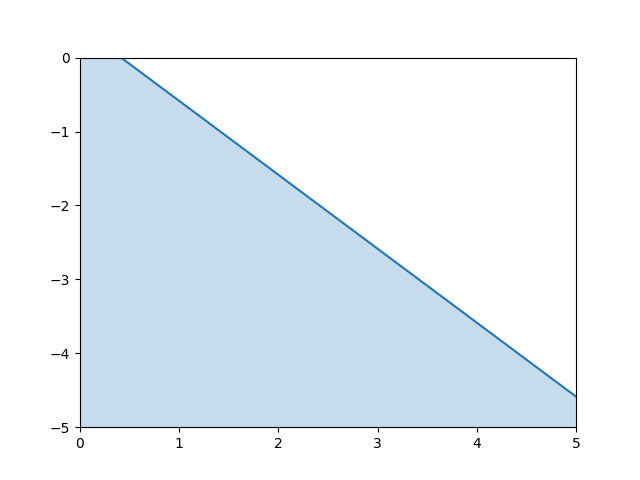

interactive(children=(FloatSlider(value=0.5, description='r_s', max=1.0, min=0.01, step=0.01), Output()), _dom…

In [3]:
plot_integration_area_main_csit()

In [4]:
from bounds_main_csit import lower_bound_main_csit, upper_bound_main_csit, independent_main_csit

In [5]:
def plot_vs_snrbob_main_csit():
    r_c = 0  # not needed when CSIT is available
    snr_db = np.arange(-5, 15.5, .5)
    snr_bob = 10**(snr_db/10)
    fig, axs = plt.subplots()
    curves = {"lower": lower_bound_main_csit, "upper": upper_bound_main_csit, 
              "independent": independent_main_csit}
    plots = {k: axs.semilogy(snr_db, np.ones(len(snr_db)))[0] for k in curves.keys()}
    axs.set_ylim([1e-5, 1.1])
    def update_plot(snr_eve_db, lam_x, lam_y, r_s):
        snr_eve = 10**(snr_eve_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        #print(snr_db)
        #print(lam_xt>lam_yt)
        for _name, _func in curves.items():
            plots[_name].set_ydata(_func(r_s, r_c, lam_xt, lam_yt))
    interact(update_plot, snr_eve_db=(-10, 10, 1), lam_x=(0.5, 2, .1), lam_y=(0.5, 2, .1), r_s=(0.01, 0.5, 0.01))

<IPython.core.display.Javascript object>


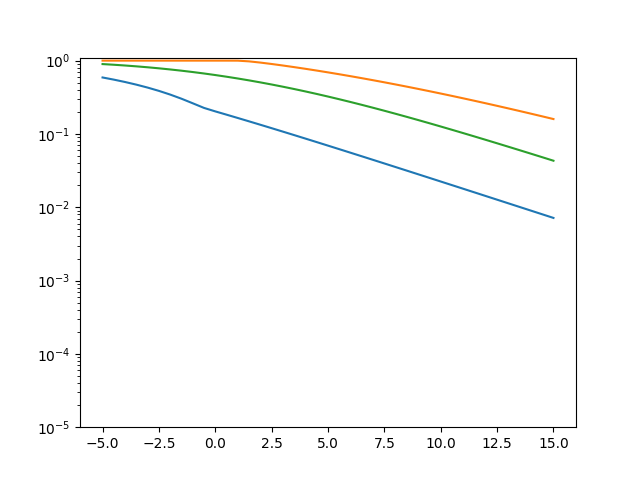

interactive(children=(IntSlider(value=0, description='snr_eve_db', max=10, min=-10), FloatSlider(value=1.20000…

In [6]:
plot_vs_snrbob_main_csit()

In [7]:
def plot_vs_snreve_main_csit():
    r_c = 0  # not needed when CSIT is available
    snr_db_eve = np.arange(-30, 15.5, .5)
    snr_eve = 10**(snr_db_eve/10)
    fig, axs = plt.subplots()
    curves = {"lower": lower_bound_main_csit, "upper": upper_bound_main_csit, 
              "independent": independent_main_csit}
    plots = {k: axs.semilogy(snr_db_eve, np.ones(len(snr_db_eve)))[0] for k in curves.keys()}
    axs.set_ylim([1e-3, 1.1])
    def update_plot(snr_bob_db, lam_x, lam_y, r_s):
        snr_bob = 10**(snr_bob_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        #print(snr_db)
        #print(lam_xt>lam_yt)
        for _name, _func in curves.items():
            plots[_name].set_ydata(_func(r_s, r_c, lam_xt, lam_yt))
    interact(update_plot, snr_bob_db=(-10, 10, 1), lam_x=(0.5, 2, .1), lam_y=(0.5, 2, .1), r_s=(0.01, 0.5, 0.01))

<IPython.core.display.Javascript object>


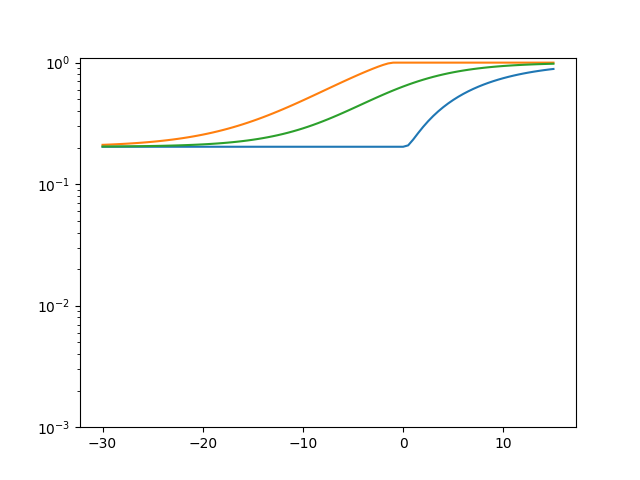

interactive(children=(IntSlider(value=0, description='snr_bob_db', max=10, min=-10), FloatSlider(value=1.20000…

In [8]:
plot_vs_snreve_main_csit()

In [9]:
def plot_vs_rs_main_csit():
    r_c = 0  # not needed when CSIT is available
    r_s = np.logspace(-3, 1, 40)
    fig, axs = plt.subplots()
    curves = {"lower": lower_bound_main_csit, "upper": upper_bound_main_csit, 
              "independent": independent_main_csit}
    plots = {k: axs.loglog(r_s, np.ones(len(r_s)))[0] for k in curves.keys()}
    axs.set_ylim([1e-4, 1.1])
    def update_plot(snr_bob_db, snr_eve_db, lam_x, lam_y):
        snr_bob = 10**(snr_bob_db/10)
        snr_eve = 10**(snr_eve_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        #print(snr_db)
        #print(lam_xt>lam_yt)
        for _name, _func in curves.items():
            plots[_name].set_ydata(_func(r_s, r_c, lam_xt, lam_yt))
    interact(update_plot, snr_bob_db=(-10, 10, 1), snr_eve_db=(-10, 10, 1), lam_x=(0.5, 2, .1), lam_y=(0.5, 2, .1))

<IPython.core.display.Javascript object>


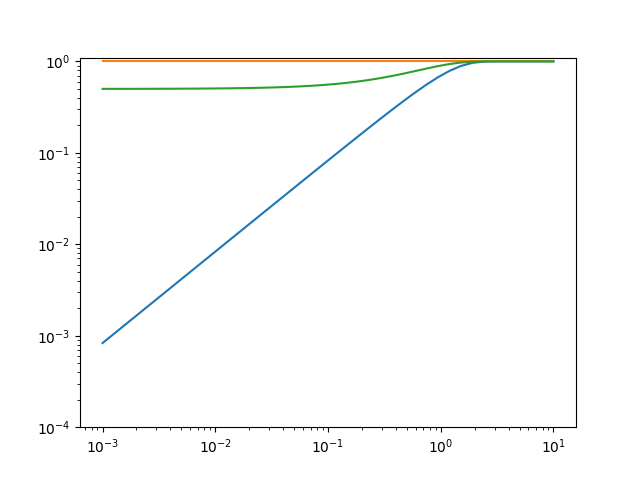

interactive(children=(IntSlider(value=0, description='snr_bob_db', max=10, min=-10), IntSlider(value=0, descri…

In [10]:
plot_vs_rs_main_csit()

## Optimal Distributions

In [11]:
def cdf_xt(x, lam=1):
    return np.maximum(1.-np.exp(-x*lam), 0)

def cdf_yt(y, lam=1):
    return np.minimum(np.exp(y*lam), 1)

def copula_lower(a, b, r_s=1, lam_xt=1, lam_yt=1):
    t = lower_bound_main_csit(r_s, 1, lam_xt, lam_yt)
    c = np.minimum(a, b)
    idx_t = np.where(np.logical_and(a >= t, b >= t))
    c[idx_t] = np.maximum(a[idx_t] + b[idx_t] - 1, t)
    return c

In [53]:
from matplotlib.gridspec import GridSpec

def plot_joint_lower_dist():
    xlim = [0, 5]
    ylim = [0, 5]
    fig = plt.figure(num="Joint Distribution Lower Bound")
    gs = GridSpec(4,4)
    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])
    ax_joint.set_xlabel("$\\tilde{X}$")
    ax_joint.set_ylabel("$\\tilde{Y}$")
    ax_marg_x.xaxis.tick_top()
    ax_marg_y.yaxis.tick_right()
    x, stepx = np.linspace(*xlim, retstep=True)
    y, stepy = np.linspace(*ylim, retstep=True)
    X, Y = np.meshgrid(x, y)
    def update_plot(snr_bob_db=0, snr_eve_db=0, r_s=1, lam_x=1, lam_y=1):
        snr_bob = 10**(snr_bob_db/10)
        snr_eve = 10**(snr_eve_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        Xt = snr_bob*X
        Yt = -2**r_s*snr_eve*Y
        marg_cdf_xt = cdf_xt(Xt, lam=lam_xt)
        marg_cdf_yt = cdf_yt(Yt, lam=lam_yt)
        #marg_cdf_yt = cdf_xt(Y, lam=lam_yt)
        joint_cdf = copula_lower(marg_cdf_xt, marg_cdf_yt, r_s=r_s, lam_xt=lam_xt, lam_yt=lam_yt)
        _gradx = np.gradient(joint_cdf, snr_bob*stepx, axis=0)
        joint_pdf = np.gradient(_gradx, -2**r_s*snr_eve*stepy, axis=1)
        marg_x = marg_cdf_xt[0, :]
        marg_y = marg_cdf_yt[:, 0]
        for _ax in [ax_joint, ax_marg_x, ax_marg_y]:
            _ax.clear()
        ax_marg_x.set_xlim(xlim)
        ax_marg_x.set_ylim([0, 1])
        ax_marg_y.set_xlim([0, 1])
        ax_marg_y.set_ylim(ylim)
        ax_joint.pcolormesh(X, Y, joint_pdf, vmin=0, vmax=1)
        ax_marg_x.plot(x, marg_x)
        ax_marg_y.plot(marg_y, y)
        fig.canvas.draw_idle()
    interact(update_plot, snr_bob_db=(-5, 5), snr_eve_db=(-5, 5), r_s=(.2, 2, .1),
             lam_x=(.1, 3, .1), lam_y=(.1, 3., .1))
    #plt.colorbar()

<IPython.core.display.Javascript object>


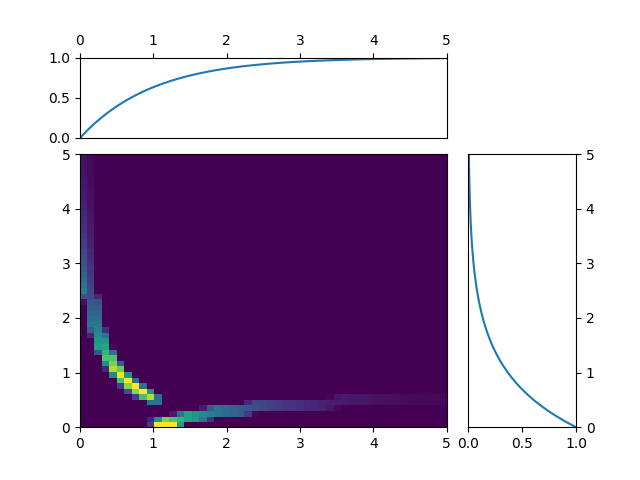

interactive(children=(IntSlider(value=0, description='snr_bob_db', max=5, min=-5), IntSlider(value=0, descript…

In [54]:
plot_joint_lower_dist()

In [55]:
def copula_upper(a, b, r_s=1, lam_xt=1, lam_yt=1):
    r = upper_bound_main_csit(r_s, 1, lam_xt, lam_yt)
    c = np.minimum(a, b)
    idx_r = np.where(np.logical_and(a <= r, b <= r))
    c[idx_r] = np.maximum(a[idx_r] + b[idx_r] - r, 0)
    return c

In [60]:
def plot_joint_upper_dist():
    xlim = [0, 5]
    ylim = [0, 5]
    fig = plt.figure(num="Joint Distribution Upper Bound")
    gs = GridSpec(4,4)
    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])
    ax_joint.set_xlabel("$\\tilde{X}$")
    ax_joint.set_ylabel("$\\tilde{Y}$")
    ax_marg_x.xaxis.tick_top()
    ax_marg_y.yaxis.tick_right()
    x, stepx = np.linspace(*xlim, retstep=True)
    y, stepy = np.linspace(*ylim, retstep=True)
    X, Y = np.meshgrid(x, y)
    def update_plot(snr_bob_db=0, snr_eve_db=0, r_s=1, lam_x=1, lam_y=1):
        snr_bob = 10**(snr_bob_db/10)
        snr_eve = 10**(snr_eve_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        Xt = snr_bob*X
        Yt = -2**r_s*snr_eve*Y
        marg_cdf_xt = cdf_xt(Xt, lam=lam_xt)
        marg_cdf_yt = cdf_yt(Yt, lam=lam_yt)
        joint_cdf = copula_upper(marg_cdf_xt, marg_cdf_yt, r_s=r_s, lam_xt=lam_xt, lam_yt=lam_yt)
        _gradx = np.gradient(joint_cdf, snr_bob*stepx, axis=0)
        joint_pdf = np.gradient(_gradx, -2**r_s*snr_eve*stepy, axis=1)
        marg_x = marg_cdf_xt[0, :]
        marg_y = marg_cdf_yt[:, 0]
        for _ax in [ax_joint, ax_marg_x, ax_marg_y]:
            _ax.clear()
        ax_marg_x.set_xlim(xlim)
        ax_marg_x.set_ylim([0, 1])
        ax_marg_y.set_xlim([0, 1])
        ax_marg_y.set_ylim(ylim)
        ax_joint.pcolormesh(X, Y, joint_pdf, vmin=0, vmax=1)
        ax_marg_x.plot(x, marg_x)
        ax_marg_y.plot(marg_y, y)
        fig.canvas.draw_idle()
    interact(update_plot, snr_bob_db=(-5, 5), snr_eve_db=(-5, 5), r_s=(.1, 2, .1),
             lam_x=(.1, 3, .1), lam_y=(.1, 3., .1))
    #plt.colorbar()

<IPython.core.display.Javascript object>


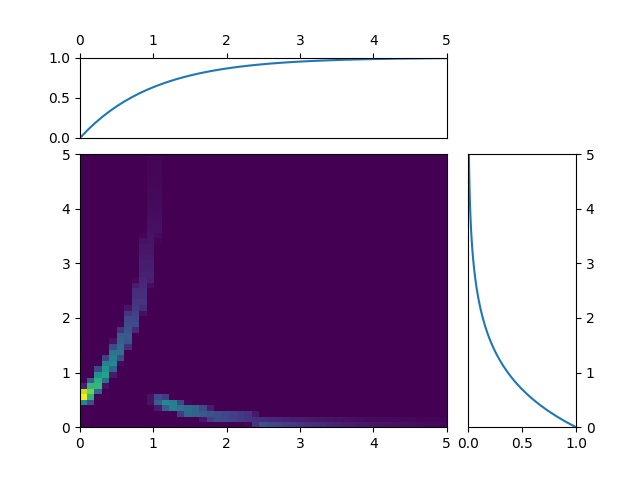

interactive(children=(IntSlider(value=0, description='snr_bob_db', max=5, min=-5), IntSlider(value=0, descript…

In [61]:
plot_joint_upper_dist()

# No CSI-T

Add more information about this...

In [14]:
def plot_integration_area_no_csit():
    fig, axs = plt.subplots()
    y = np.linspace(-5, 0)
    def update_plot(r_s, r_c):
        x = np.maximum((2**r_s-1) - y, 2**(r_s+r_c)-1)
        axs.clear()
        axs.set_xlim([0, 5])
        axs.set_ylim([-5, 0])
        axs.plot(x, y)
        axs.fill_betweenx(y, x, 0, alpha=.25)
    interact(update_plot, r_s=(.01, 1, .01), r_c=(.01, 1, .01))

<IPython.core.display.Javascript object>


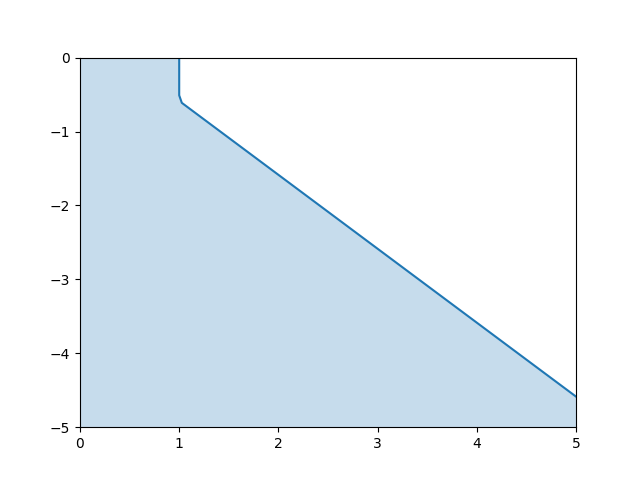

interactive(children=(FloatSlider(value=0.5, description='r_s', max=1.0, min=0.01, step=0.01), FloatSlider(val…

In [15]:
plot_integration_area_no_csit()

In [16]:
from bounds_no_csit import lower_bound_no_csit, upper_bound_no_csit, independent_no_csit

In [17]:
def plot_no_csit_bounds():
    snr_db = np.arange(-5, 16, 0.5)
    snr_bob = 10**(snr_db/10)
    curves = {"lower": lower_bound_no_csit,
              "upper": upper_bound_no_csit,
              "indep": independent_no_csit}
    fig, ax = plt.subplots()
    plots = {k: ax.semilogy(snr_db, np.ones(len(snr_db)))[0] for k in curves.keys()}
    ax.set_xlabel("SNR [dB]")
    ax.set_ylabel("Outage Probability")
    ax.set_ylim([0.01, 1.1])
    def update_plot(snr_eve_db, r_s, r_c, lam_x, lam_y):
        snr_eve = 10**(snr_eve_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        for _name, _func in curves.items():
            plots[_name].set_ydata(_func(r_s, r_c, lam_xt, lam_yt))
    interact(update_plot, snr_eve_db=(-5, 10), r_s=(0.01, 2, 0.01), r_c=(0.01, 2, 0.01),
             lam_x=(0.01, 3, 0.03), lam_y=(0.01, 3, 0.03))
    plt.show()

<IPython.core.display.Javascript object>


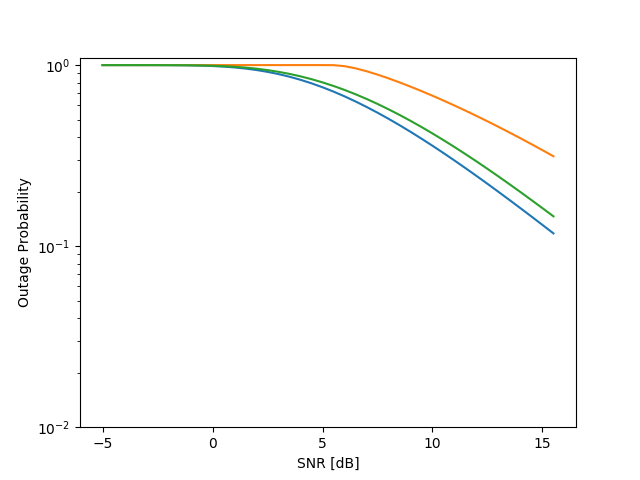

interactive(children=(IntSlider(value=2, description='snr_eve_db', max=10, min=-5), FloatSlider(value=1.0, des…

In [18]:
plot_no_csit_bounds()

# Comparison No CSIT vs Main CSIT

In [19]:
def plot_comparison_bounds():
    snr_db = np.arange(-5, 16, 0.1)
    snr_bob = 10**(snr_db/10)
    curves = {"Lower - No CSIT": lower_bound_no_csit,
              "Upper - No CSIT": upper_bound_no_csit,
              "Indep - No CSIT": independent_no_csit,
              "Lower - Main CSIT": lower_bound_main_csit,
              "Upper - Main CSIT": upper_bound_main_csit,
              "Indep - Main CSIT": independent_main_csit}
    fig, ax = plt.subplots()
    plots = {k: ax.semilogy(snr_db, np.ones(len(snr_db)), label=k)[0] for k in curves.keys()}
    ax.set_xlabel("SNR [dB]")
    ax.set_ylabel("Outage Probability")
    ax.set_ylim([0.001, 1.1])
    ax.legend()
    def update_plot(snr_eve_db, r_s, r_c, lam_x, lam_y):
        snr_eve = 10**(snr_eve_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        for _name, _func in curves.items():
            plots[_name].set_ydata(_func(r_s, r_c, lam_xt, lam_yt))
    interact(update_plot, snr_eve_db=(-5, 10), r_s=(0.01, 2, 0.01), r_c=(0.01, 2, 0.01),
             lam_x=(0.01, 3, 0.03), lam_y=(0.01, 3, 0.03))
    plt.show()

<IPython.core.display.Javascript object>


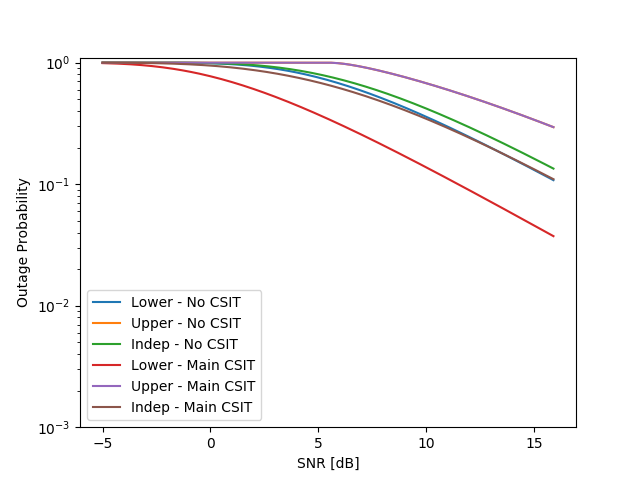

interactive(children=(IntSlider(value=2, description='snr_eve_db', max=10, min=-5), FloatSlider(value=1.0, des…

In [20]:
plot_comparison_bounds()